# Visualization of birdsong phrases

Generates PCA and TSNE visualizations of data. Visualizes spectrogram of phrases.

# Import libraries

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import freqz
import os
import glob
import pandas as pd
import copy
import seaborn as sns
import re
import pickle
import operator
import IPython.display as ipd
import itertools
import numpy.random as rng
import random

# Utility functions

In [3]:
def filter_by_freq(target,threshold):
    filtered = dict()
    for key in target:
        if len(target[key]) >= threshold:
            filtered[key] = target[key]
    return filtered

#Load support set from selection
def create_support_set(sel_keys,selection,total,filtered,full):
    support_set = dict()
    for i in range(0, len(sel_keys)):
        support_set[sel_keys[i]] = filtered[sel_keys[i]][selection[i]]

    #If true adds rare phrases (those with less than 12 instances)
    if full:
        #load support set for rare phrases (with less than 12 tokens)
        rare_phrases = { k : total[k] for k in set(total) - set(filtered) }
        for key in rare_phrases.keys():
            support_set[key]= librosa.load(rare_phrases[key][0]) #Choose the first one
    return support_set 

def remv_support_set(sel_keys,selection,filtered):
    #Remove support set instances from filtered set. 
    new_filtered = copy.deepcopy(filtered)
    for i in range(len(sel_keys)):
      a = new_filtered[sel_keys[i]]
      del a[selection[i]]
      new_filtered[sel_keys[i]] = a
    return new_filtered

def split_set(new_filtered,train_size):
  #Returns train and test set
  train = dict()
  test = dict()
  for k in new_filtered.keys():
    #train[k],test[k] = train_test_split(new_filtered[k],train_size=train_size, random_state=rand_state)
    train[k],test[k] = train_test_split(new_filtered[k],train_size=train_size)
  return train, test

# Load features from all phrases

In [4]:
with open("features_total.pkl", "rb") as input_file:
  total_features = pickle.load(input_file)

In [5]:
#Transpose vectors and compute decibels
total_features_db = dict()
for k in total_features.keys():
  for i in range(len(total_features[k])):
    total_features[k][i] = lb.amplitude_to_db(total_features[k][i],top_db=65.0)
    #total_features[k][i] = np.transpose(total_features[k][i])

In [6]:
#Get most common phrases (filter)
filt_features = filter_by_freq(total_features,12)

In [7]:
#Number of phrases with at least 12 exemplars
len(filt_features)

32

In [8]:
#Total phrases after filtering
sum([len(filt_features[k]) for k in filt_features.keys()])

1033

# Support Set

Test set contains different instances of each of the 32 classes but not seen in training.

In [9]:
#Get traning and test set. Specify number of shots (# phrases used as support).
shots = 7
train_set, test_set = split_set(filt_features,shots) 

In [10]:
#Create support set from averages
support_set = dict()
for k in train_set.keys():
  support_set[k] = np.mean(train_set[k],axis=0)

In [11]:
#Input a phrase id (aa,aj,etc.) to see how many phrases are of that type
len(filt_features['aa'])

55

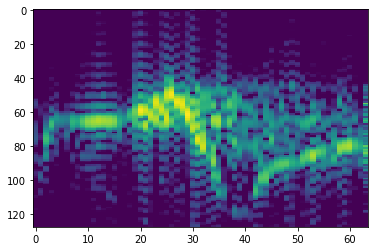

In [12]:
#Visualize phrase
plt.imshow(np.transpose(filt_features['aa'][0]),aspect='auto')

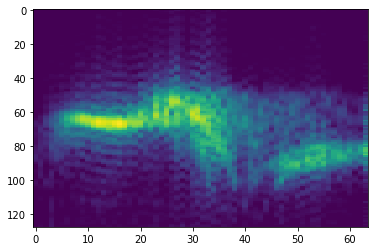

In [13]:
#Visualize support phrase (average of shots)
plt.imshow(np.transpose(support_set['aa']),aspect='auto')

# Retrieve data labels

In [15]:
I, L = pd.factorize(list(support_set.keys()))

In [62]:
flattened_all = []
y_all = []
y_all_names = []
for a in filt_features.keys():
  for s in filt_features[a]:
    flattened_all.append(s.flatten())
    y_all.append(L.tolist().index(a))
    y_all_names.append(a)
flattened_all = np.array(flattened_all)
y_test = np.array(y_all)
y_test_names = np.array(y_test_names)

flattened_test = []
y_test = []
y_test_names = []
for a in test_set.keys():
  for s in test_set[a]:
    flattened_test.append(s.flatten())
    y_test.append(L.tolist().index(a))
    y_test_names.append(a)
flattened_test = np.array(flattened_test)
y_test = np.array(y_test)
y_test_names = np.array(y_test_names)

In [64]:
#Contains all phrases in filtered set
flattened_all.shape

(1033, 8192)

In [66]:
#Contains only phrases in test set
flattened_test.shape

(809, 8192)

# Visualization with TSNE

In [67]:
model = TSNE(n_components=2, random_state=0,perplexity=25)

In [68]:
p = model.fit_transform(flattened_all)

In [69]:
data = pd.DataFrame(list(zip(p[:,0],p[:,1],y_all_names)),columns=["x","y","label"])

New coordinates

In [70]:
data

,x,y,label
0,35.869091,25.583107,aa
1,38.654839,27.234262,aa
2,34.964928,24.531357,aa
3,31.893480,25.928780,aa
4,36.798580,21.591093,aa
...,...,...,...
1028,6.846118,-40.538506,bx
1029,6.707617,-42.922359,bx
1030,7.452102,-40.844070,bx
1031,5.429083,-40.602409,bx


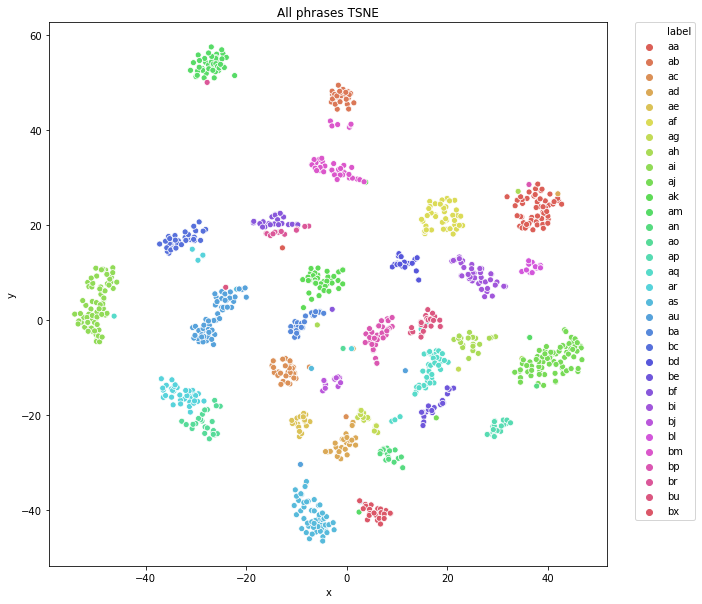

In [71]:
fig, ax = plt.subplots(figsize=(10,10))  
ax = sns.scatterplot(x="x", y="y", hue="label",data=data,palette=sns.color_palette("hls", 32))
ax.set(xlabel='x', ylabel='y',title="All phrases TSNE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [26]:
fig.savefig("AllPhrases_TSNE",bbox_inches='tight')

# PCA

In [72]:
pca = PCA(n_components=2)

In [73]:
p_comps = pca.fit_transform(flattened_all)

In [74]:
dataP = pd.DataFrame(list(zip(p_comps[:,0],p_comps[:,1],y_all_names)),columns=["x","y","label"])

In [75]:
dataP

,x,y,label
0,662.725220,-249.944839,aa
1,453.501892,-395.213074,aa
2,560.852112,-173.694183,aa
3,682.833740,192.737778,aa
4,260.398743,-255.580612,aa
...,...,...,...
1028,-259.879425,-329.722198,bx
1029,-41.908096,-419.443207,bx
1030,-158.692886,-364.916412,bx
1031,-132.149612,-328.984192,bx


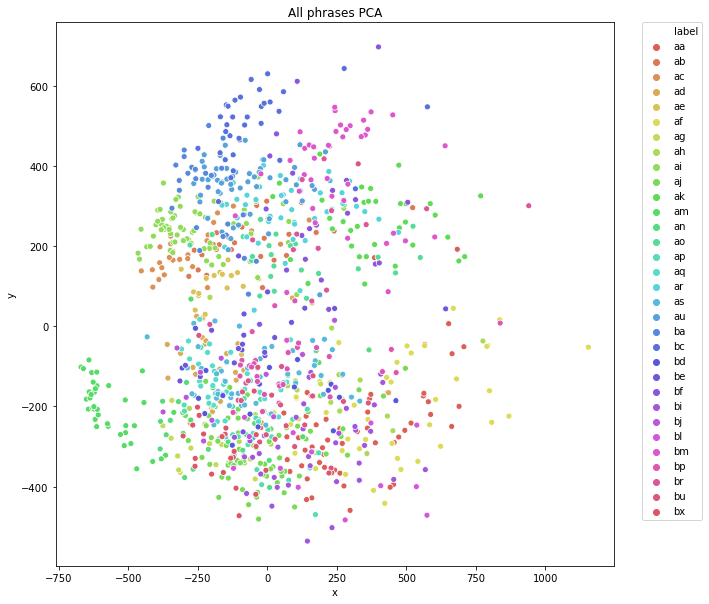

In [76]:
fig, ax = plt.subplots(figsize=(10,10))  
ax = sns.scatterplot(x="x", y="y", hue="label",data=dataP,palette=sns.color_palette("hls", 32))
ax.set(xlabel='x', ylabel='y',title="All phrases PCA")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [35]:
fig.savefig("AllPhrases_PCA",bbox_inches='tight')

# TSNE support and test

Remember the support set is obtained using the average of as much phrases as shots per class. This visualization shows how close are these averages from instances in the test set. Since the clusters are seggregated one can visually support the manifold hypothesis for this dataset. TSNE was able to find a non-linear transformation from a high dimensional space to the euclidian 2D plane where instances of the same class are clustered togheter. Test and support set are mutually exclusive.

In [77]:
a = np.array(list(support_set.values()))
a = a.reshape(32,-1)
a.shape

(32, 8192)

In [78]:
flattened_test.shape

(809, 8192)

In [79]:
test_and_support = np.concatenate((flattened_test,a))

In [80]:
test_and_support.shape

(841, 8192)

In [81]:
y_test_and_support_names = np.concatenate((y_test_names,np.array(list(support_set.keys()))))

In [82]:
modelC = TSNE(n_components=2, random_state=0,perplexity=25)

In [83]:
test_and_support_p = model.fit_transform(test_and_support)

In [84]:
# additional dimension to distinguish between training and support elements
tr_type = np.array(np.repeat("test",len(flattened_test)))
sup_type = np.array(np.repeat("support",32))
types = np.concatenate((tr_type,sup_type))

In [85]:
dataC = pd.DataFrame(list(zip(test_and_support_p[:,0],test_and_support_p[:,1],y_test_and_support_names,types)),columns=["x","y","label","type"])

In [86]:
dataC

,x,y,label,type
0,18.261368,23.406033,aa,test
1,17.816458,24.585142,aa,test
2,22.727110,26.303148,aa,test
3,18.432642,28.222820,aa,test
4,19.098097,26.699696,aa,test
...,...,...,...,...
836,18.692904,-15.774075,bm,support
837,0.645975,11.008186,bp,support
838,7.182040,-12.729576,br,support
839,3.365177,15.922555,bu,support


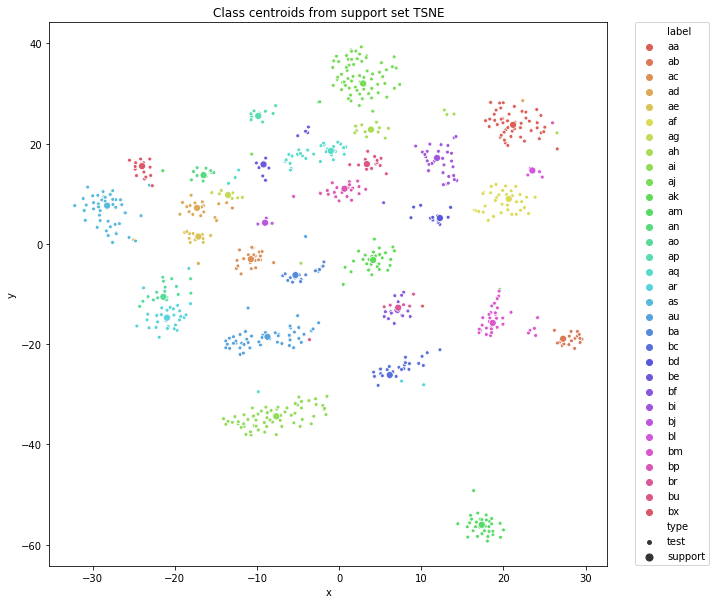

In [89]:
fig, ax = plt.subplots(figsize=(10,10))  
ax = sns.scatterplot(x="x", y="y", hue="label",data=dataC,palette=sns.color_palette("hls", 32),size="type",sizes=[15,50])
ax.set(xlabel='x', ylabel='y',title="Class centroids from support set TSNE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [90]:
fig.savefig("classCentroids_TSNE",bbox_inches='tight')